In [121]:
'''
Select a dataset:
'''
selector = 2
dataset = ['neuraltextures_raw_20s_k',  # 0
           'faceshifter_raw_20s_k',     # 1
           'lumalabs_raw_5s_k'          # 2
           ]
# format: dataset_compression_length_rPPGmethod

'''
Folders and options
'''
# video statistics (e.g. FPS per video)
path_video_stats_manipulated = '2_rPPG/'+dataset[selector]+'/stats/video_statistics_manipulated.csv'
path_video_stats_original = '2_rPPG/'+dataset[selector]+'/stats/video_statistics_original.csv'

# GRGB folders
path_GRGB_manipulated = '2_rPPG/'+dataset[selector]+'/manipulated'
path_GRGB_original = '2_rPPG/'+dataset[selector]+'/original'

# ouput folder
path_ouput = '3_features/'+dataset[selector]+'/'

lowcut = 0.65  # Low cut-off frequency (Hz) = 39 BPM [1]
highcut = 4.0  # High cut-off frequency (Hz) = 240 BPM [1]

'''
Implemented features:
- katz:     Katz Fractal Dimension [2]
- zero:     Zero-Crossings [3]
- svd:      SVD Entropy [3]
- higuchi:  Higuchi Fractal Dimension [3]
- dfa:      Detrended Fluctuation Analysis
- bpm:      BPM (using peak detection)

References:
[1] Haugg, F., Elgendi, M., & Menon, C. (2023). GRGB rPPG: An Efficient Low-Complexity Remote Photoplethysmography-Based Algorithm for Heart Rate Estimation. Bioengineering (Basel, Switzerland), 10(2), 243. https://doi.org/10.3390/bioengineering10020243
[2] Boccignone G, Conte D, Cuculo V, D’Amelio A, Grossi G, Lanzarotti R, Mortara E. (2022). pyVHR: a Python framework for remote photoplethysmography. PeerJ Computer Science 8:e929 https://doi.org/10.7717/peerj-cs.929
[3] Wang, J., Shan, C., Liu, L., & Hou, Z. (2024). Camera-based physiological measurement: Recent advances and future prospects. Neurocomputing, 127282. https://doi.org/10.1016/j.neucom.2024.127282

'''


'\nImplemented features:\n- katz:     Katz Fractal Dimension [2]\n- zero:     Zero-Crossings [3]\n- svd:      SVD Entropy [3]\n- higuchi:  Higuchi Fractal Dimension [3]\n- dfa:      Detrended Fluctuation Analysis\n- bpm:      BPM (using peak detection)\n\nReferences:\n[1] Haugg, F., Elgendi, M., & Menon, C. (2023). GRGB rPPG: An Efficient Low-Complexity Remote Photoplethysmography-Based Algorithm for Heart Rate Estimation. Bioengineering (Basel, Switzerland), 10(2), 243. https://doi.org/10.3390/bioengineering10020243\n[2] Boccignone G, Conte D, Cuculo V, D’Amelio A, Grossi G, Lanzarotti R, Mortara E. (2022). pyVHR: a Python framework for remote photoplethysmography. PeerJ Computer Science 8:e929 https://doi.org/10.7717/peerj-cs.929\n[3] Wang, J., Shan, C., Liu, L., & Hou, Z. (2024). Camera-based physiological measurement: Recent advances and future prospects. Neurocomputing, 127282. https://doi.org/10.1016/j.neucom.2024.127282\n\n'

In [122]:
''' Various functions '''
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
import antropy as ant

# Load the CSV file into a pandas DataFrame
stats_original = pd.read_csv(path_video_stats_original)
stats_manipulated = pd.read_csv(path_video_stats_manipulated)

def get_fps(filename, df):
    filename = filename.strip()
    if filename in df['Filename'].values:
        fps_value = df.loc[df['Filename'] == filename, 'FPS'].values[0]
        return fps_value
    else:
        return None
    
def get_fps2(filename, df):
    filename = int(filename.strip()) # INT
    if filename in df['Filename'].values:
        fps_value = df.loc[df['Filename'] == filename, 'FPS'].values[0]
        return fps_value
    else:
        return None
    
def get_csvs(root_folder):
    csv_list = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(('.csv')):
                file_path = os.path.join(root, file)
                csv_list.append(file_path)
    return csv_list

def extract_filename(file_path):
    # filename pattern (e.g., "002_006")
    match = re.search(r'([^/]+)\.csv$', file_path)
    if match:
        return match.group(1)
    else:
        return None
    


''' 
FILTER 
'''
def bandpass_filter(data, lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band') 
    y = filtfilt(b, a, data)
    return y

''' 
BPM detection
'''
def get_bpm_peaks(data):
    peaks, _ = find_peaks(data, distance=fps/2) # ‹—— DISTANCE  2.8
    peak_intervals = np.diff(peaks) / fps
    heart_rate = 60.0 / np.mean(peak_intervals)
    return heart_rate

In [123]:
''' Export rPPG, FFT and heatmap as png '''
# def save_rppg_plot(signal, folder, filename):
#     t = np.linspace(0, len(signal), len(signal))  # Time vector

#     peaks, _ = find_peaks(signal, height=0)
#     zero_crossings = np.where(np.diff(np.sign(signal)))[0]

#     num_peaks = len(peaks)
#     num_zero_crossings = len(zero_crossings)

#     signal_length = len(signal)
#     heatmap_size = int(np.sqrt(signal_length))  # Get closest square shape
#     bvp_2d = np.reshape(signal[:heatmap_size**2], (heatmap_size, heatmap_size))

#     bpm_peaks_rppg = get_bpm_peaks(signal)
#     ratio = bpm_peaks_rppg/num_zero_crossings

#     # FFT
#     frequencies = np.fft.fftfreq(len(signal), d=(t[1]-t[0]))  # Compute FFT frequencies
#     fft_values = np.abs(np.fft.fft(signal))  # Compute FFT magnitudes
#     positive_frequencies = frequencies[frequencies >= 0]
#     positive_fft_values = fft_values[:len(positive_frequencies)]  # Corresponding FFT values

#     # PLOT
#     plt.figure(figsize=(8, 10))
#     plt.suptitle(filename+' '+dataset[selector], fontsize=16)

#     # Define a GridSpec with 3 rows and 1 column
#     gs = plt.GridSpec(3, 1, height_ratios=[1, 1, 1])  # Equal height for each plot, adjust ratios as needed

#     # Plot 1: Signal
#     plt.subplot(gs[0])
#     plt.plot(t, signal, color='blue', label='rPPG Signal')
#     plt.plot(peaks, signal[peaks], "rx", label=f'Peaks ({num_peaks})')
#     plt.plot(zero_crossings, signal[zero_crossings], "gx", label=f'Zero Crossings ({num_zero_crossings})')
#     plt.legend(loc='lower right')
#     plt.title(f'rPPG ({bpm_peaks_rppg:.2f} BPM)')
#     plt.xlabel('Sample Number')
#     plt.ylabel('Amplitude')
#     plt.grid(True)

#     # Plot 2: FFT
#     plt.subplot(gs[1])
#     plt.plot(positive_frequencies, positive_fft_values, color='blue', label='FFT')
#     plt.title('FFT')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Amplitude')
#     plt.grid(True)

#     # Plot 3: Heatmap
#     plt.subplot(gs[2])
#     sns.heatmap(bvp_2d, cmap='Blues', cbar=False)
#     plt.title('Heatmap (rPPG)')

#     plt.tight_layout()
#     plt.savefig(path_ouput + folder + '/'+ filename + '.png')


' Export rPPG, FFT and heatmap as png '

In [124]:
df_manipulated = pd.DataFrame(columns=['bpm', 'zero','katz','svd','dfa','higuchi'])
csv_list_manipulated = get_csvs(path_GRGB_manipulated)

for i in csv_list_manipulated:
    filename = extract_filename(i)
    try:
        rPPG_signal_raw = pd.read_csv(i, sep=',', header=None).transpose()
    except pd.errors.EmptyDataError:
        print(f"Excluded due to empty file: {filename}")

    rPPG_signal = rPPG_signal_raw.dropna()
    fps = get_fps(filename,stats_manipulated)
    
    if len(rPPG_signal) < 30:
        print('excluded: ', filename)
        continue

    rPPG_signal_filter = bandpass_filter(rPPG_signal[0], lowcut, highcut, fps)
    rPPG_signal_filter = (rPPG_signal_filter - np.mean(rPPG_signal_filter)) / np.std(rPPG_signal_filter)

    bpm_peaks_rppg = get_bpm_peaks(rPPG_signal_filter)

    df_manipulated.loc[filename, 'bpm'] = bpm_peaks_rppg
    df_manipulated.loc[filename, 'zero'] = ant.num_zerocross(rPPG_signal_filter)
    df_manipulated.loc[filename, 'katz'] = ant.katz_fd(rPPG_signal_filter)
    df_manipulated.loc[filename, 'svd'] = ant.svd_entropy(rPPG_signal_filter, normalize=True)
    df_manipulated.loc[filename, 'dfa'] = ant.detrended_fluctuation(rPPG_signal_filter)
    df_manipulated.loc[filename, 'higuchi'] = ant.higuchi_fd(rPPG_signal_filter)

    #save_rppg_plot(rPPG_signal_filter,'manipulated',filename)


In [125]:
df_original = pd.DataFrame(columns=['bpm', 'zero','katz','svd','dfa','higuchi'])
csv_list_original = get_csvs(path_GRGB_original)

for i in csv_list_original:
    filename = extract_filename(i)
    try:
        rPPG_signal_raw = pd.read_csv(i, sep=',', header=None).transpose()
    except pd.errors.EmptyDataError:
        print(f"Excluded due to empty file: {filename}")

    rPPG_signal = rPPG_signal_raw.dropna()

    fps = get_fps2(filename, stats_original)
    
    if fps is None:
        print(f"Excluded due to None FPS: {filename}")
        continue  # Skip this iteration if FPS is None
    
    if len(rPPG_signal) < 30:
        print(f"Excluded due to small length: {filename}")
        continue

    rPPG_signal_filter = bandpass_filter(rPPG_signal[0], lowcut, highcut, fps)
    rPPG_signal_filter = (rPPG_signal_filter - np.mean(rPPG_signal_filter)) / np.std(rPPG_signal_filter)
    
    bpm_peaks_rppg = get_bpm_peaks(rPPG_signal_filter)
    df_original.loc[filename, 'bpm'] = bpm_peaks_rppg
    df_original.loc[filename, 'zero'] = ant.num_zerocross(rPPG_signal_filter)
    df_original.loc[filename, 'katz'] = ant.katz_fd(rPPG_signal_filter)
    df_original.loc[filename, 'svd'] = ant.svd_entropy(rPPG_signal_filter, normalize=True)
    df_original.loc[filename, 'dfa'] = ant.detrended_fluctuation(rPPG_signal_filter)
    df_original.loc[filename, 'higuchi'] = ant.higuchi_fd(rPPG_signal_filter)
    
    #save_rppg_plot(rPPG_signal_filter,'original',filename)

Excluded due to empty file: 221
Excluded due to empty file: 456


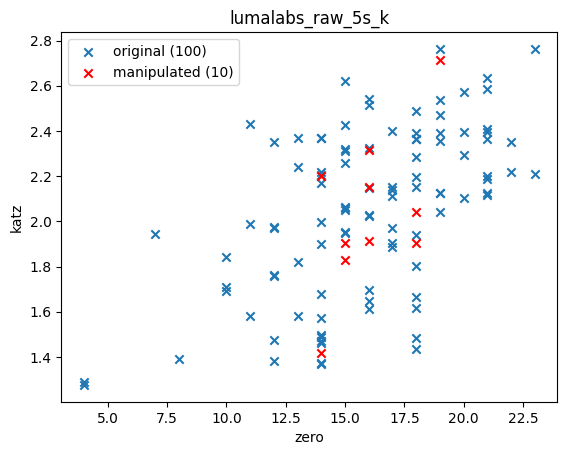

In [126]:
x = 'zero'
y = 'katz'
plt.scatter(df_original[x],df_original[y], marker='x',label='original'+f' ({len(df_original)})', alpha=1)
plt.scatter(df_manipulated[x],df_manipulated[y], marker='x',label='manipulated'+f' ({len(df_manipulated)})', color='red', alpha=1)
plt.xlabel(x)
plt.ylabel(y)
plt.title(dataset[selector])
plt.legend()
plt.show()

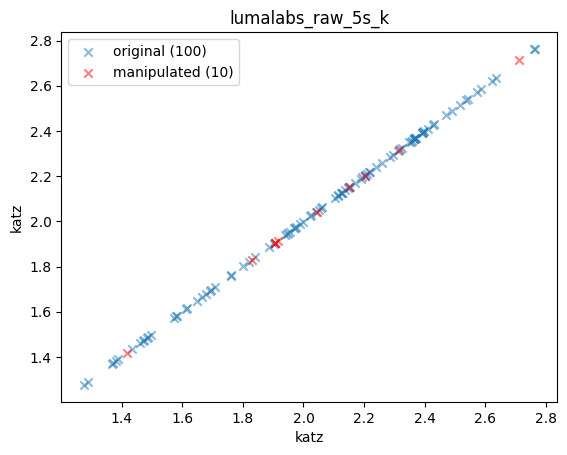

In [127]:
x = 'katz'
y = 'katz'
plt.scatter(df_original[x],df_original[y], marker='x',label='original'+f' ({len(df_original)})', alpha=0.5)
plt.scatter(df_manipulated[x],df_manipulated[y], marker='x',label='manipulated'+f' ({len(df_manipulated)})', color='red', alpha=0.5)
plt.xlabel(x)
plt.ylabel(y)
plt.title(dataset[selector])
plt.legend()
plt.show()

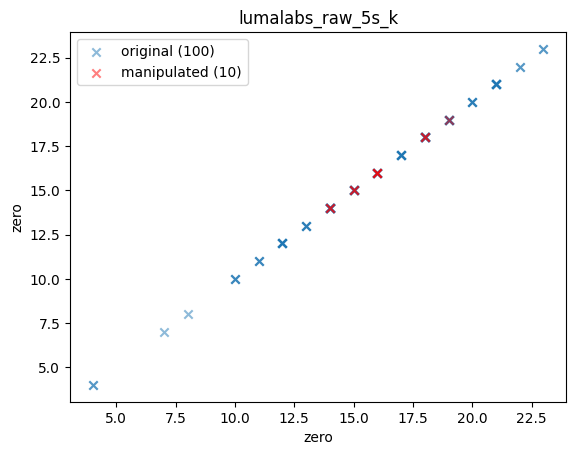

In [128]:
x = 'zero'
y = 'zero'
plt.scatter(df_original[x],df_original[y], marker='x',label='original'+f' ({len(df_original)})', alpha=0.5)
plt.scatter(df_manipulated[x],df_manipulated[y], marker='x',label='manipulated'+f' ({len(df_manipulated)})', color='red', alpha=0.5)
plt.xlabel(x)
plt.ylabel(y)
plt.title(dataset[selector])
plt.legend()
plt.show()

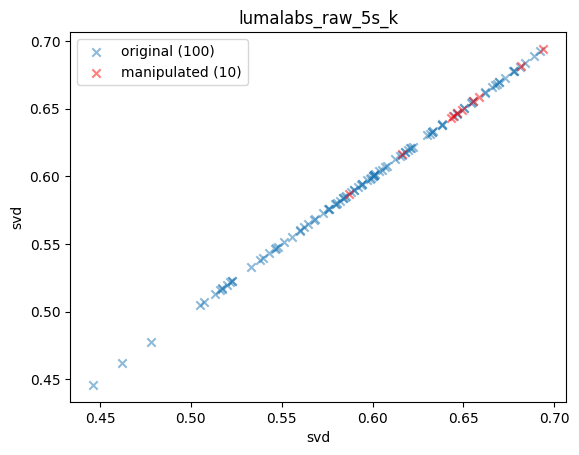

In [129]:
x = 'svd'
y = 'svd'
plt.scatter(df_original[x],df_original[y], marker='x',label='original'+f' ({len(df_original)})', alpha=0.5)
plt.scatter(df_manipulated[x],df_manipulated[y], marker='x',label='manipulated'+f' ({len(df_manipulated)})', color='red', alpha=0.5)
plt.xlabel(x)
plt.ylabel(y)
plt.title(dataset[selector])
plt.legend()
plt.show()

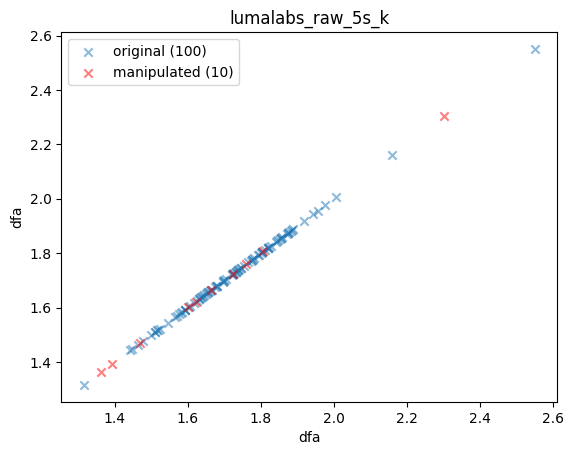

In [130]:
x = 'dfa'
y = 'dfa'
plt.scatter(df_original[x],df_original[y], marker='x',label='original'+f' ({len(df_original)})', alpha=0.5)
plt.scatter(df_manipulated[x],df_manipulated[y], marker='x',label='manipulated'+f' ({len(df_manipulated)})', color='red', alpha=0.5)
plt.xlabel(x)
plt.ylabel(y)
plt.title(dataset[selector])
plt.legend()
plt.show()

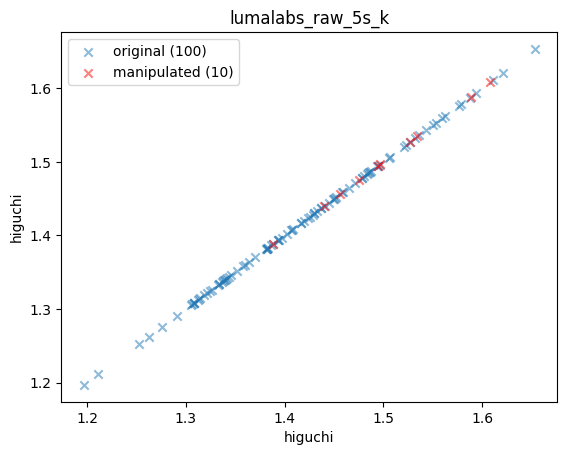

In [131]:
x = 'higuchi'
y = 'higuchi'
plt.scatter(df_original[x],df_original[y], marker='x',label='original'+f' ({len(df_original)})', alpha=0.5)
plt.scatter(df_manipulated[x],df_manipulated[y], marker='x',label='manipulated'+f' ({len(df_manipulated)})', color='red', alpha=0.5)
plt.xlabel(x)
plt.ylabel(y)
plt.title(dataset[selector])
plt.legend()
plt.show()

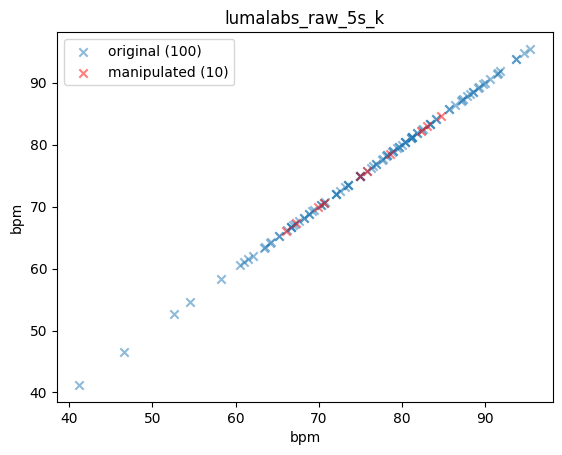

In [132]:
x = 'bpm'
y = 'bpm'
plt.scatter(df_original[x],df_original[y], marker='x',label='original'+f' ({len(df_original)})', alpha=0.5)
plt.scatter(df_manipulated[x],df_manipulated[y], marker='x',label='manipulated'+f' ({len(df_manipulated)})', color='red', alpha=0.5)
plt.xlabel(x)
plt.ylabel(y)
plt.title(dataset[selector])
plt.legend()
plt.show()